<a href="https://colab.research.google.com/github/Kritsakorn-64/229352-StatisticalLearning/blob/main/651610014_Lab09_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision # For utils.make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
from tqdm.auto import tqdm # For nice progress bars
from sklearn.metrics import accuracy_score

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


We will use a dataset of pizza, stead and sushi images ([source](https://donlapark.pages.dev/229352/pizza_steak_sushi.zip))

In [32]:
!unzip -q pizza_steak_sushi.zip

replace test/steak/296375.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://docs.pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

Class names: ['pizza', 'steak', 'sushi']
Class to index mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}
Number of training samples: 225
Number of testing samples: 75
Number of batches in training DataLoader: 8
Number of batches in testing DataLoader: 1


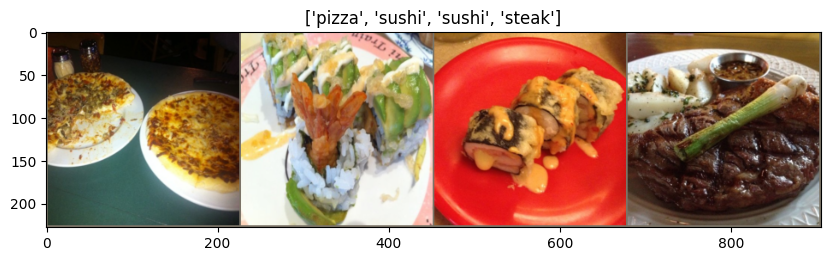

In [33]:
# 1. Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize pixel values (ImageNet statistics)
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(0.4)
])

# 2. Create datasets using ImageFolder
train_data = SimpleImageFolder(root="train", transform=data_transforms)
test_data  = SimpleImageFolder(root="test",  transform=data_transforms)

# ---- Create dataloaders ----
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
# Get class names and their mapping
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Class names: {class_names}")
print(f"Class to index mapping: {class_to_idx}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# 3. Create DataLoaders
BATCH_SIZE = 32  # You can experiment with different batch sizes

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0   # แนะนำใส่ num_workers=0 ถ้า run บน Windows/Notebook
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=len(test_data),  # ใช้ batch ใหญ่สุดใน test เพื่อประเมินทีเดียว
    shuffle=False,
    num_workers=0
)

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in testing DataLoader: {len(test_dataloader)}")

# Let's visualize a sample image and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Undo normalization
    inp = np.clip(inp, 0, 1) # Clip pixel values to [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4]) # Show first 4 images

plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.show()

In [34]:
# Download the dataset
!wget https://donlapark.pages.dev/229352/pizza_steak_sushi.zip

--2025-09-22 04:57:34--  https://donlapark.pages.dev/229352/pizza_steak_sushi.zip
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip.1’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.09s   

2025-09-22 04:57:34 (172 MB/s) - ‘pizza_steak_sushi.zip.1’ saved [15737296/15737296]



In [35]:
# Define the SimpleImageFolder class if it's not already defined
import os
from PIL import Image
from torch.utils.data import Dataset

class SimpleImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = []
        self.class_to_idx = {}
        self.samples = []

        classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.classes = [cls_name for cls_name in self.class_to_idx.keys()]

        for cls_name in classes:
            cls_path = os.path.join(root, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                if os.path.isfile(img_path):
                    self.samples.append((img_path, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB") # Ensure image is RGB
        if self.transform:
            img = self.transform(img)
        return img, label

## Part 1: Implement and Train LeNet

LeNet-5 is one of the earliest convolutional neural networks, developed by Yann LeCun et al. in the 1990s. While originally designed for smaller images (like MNIST digits), we will adapt its architecture for our 224x224 pixel images.

![lenet5](http://d2l.ai/_images/lenet.svg)

### LeNet Architecture (Adapted for 224x224 input, 3 output classes):

1.  **Input Layer**: 3x224x224 image (RGB channels).
2.  **Conv1**: ([Conv2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
    *   Input Channels: 3
    *   Output Channels: 6
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
3.  **Pool1**: ([MaxPool2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
4.  **Conv2**:
    *   Input Channels: 6
    *   Output Channels: 16
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
5.  **Pool2**:
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
6.  **Flatten**: Flatten the 3D feature maps into a 1D vector.
    *   *Hint*: After Pool2, the feature map size will be `16 * (something) * (something)`. You'll need to calculate this dimension based on the input size and the conv/pool operations.
        *   Input (224x224) -> Conv1 (224-5+1 = 220x220)
        *   Pool1 (220/2 = 110x110)
        *   Conv2 (110-5+1 = 106x106)
        *   Pool2 (106/2 = 53x53)
        *   So, the output of Pool2 will be `16 * 53 * 53`.
7.  **FC1 (Fully Connected 1)**:
    *   Input Features: `16 * 53 * 53`
    *   Output Features: 120
    *   Activation: ReLU
8.  **FC2 (Fully Connected 2)**:
    *   Input Features: 120
    *   Output Features: 84
    *   Activation: ReLU
9.  **Output Layer (FC3)**:
    *   Input Features: 84
    *   Output Features: 3 (for pizza, steak, sushi)

**Your Task:**
1.  Implement the `LeNet` class following the architecture above.
2.  Instantiate the model and move it to the `device` (GPU/CPU).
3.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
4.  Train the LeNet model for a few epochs (e.g., 5-10).
5.  Evaluate its performance on the test set.

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool  = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)

        # Corrected flatten size based on 224x224 input and architecture
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [39]:
lenet_model = LeNet(num_classes=3).to(device)

lenet_model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [40]:
# Training loop function (to be reused)
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    print(f"\n--- Training {model.__class__.__name__} for {num_epochs} epochs ---")
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # --------------------
        # Training phase
        # --------------------
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_dataloader:
            # 1. Move inputs and labels to device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # 2. Zero the gradient
            optimizer.zero_grad()

            # 3. Make predictions (forward pass)
            outputs = model(inputs)

            # 4. Calculate the loss
            loss = criterion(outputs, labels)

            # 5. Calculate the gradients (backward pass)
            loss.backward()

            # 6. Update model's parameters
            optimizer.step()

            # Calculate total loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_acc = train_correct / train_total
        results["train_loss"].append(epoch_train_loss)
        results["train_acc"].append(epoch_train_acc)

        # --------------------
        # Evaluation phase
        # --------------------
        model.eval()  # Set model to evaluation mode
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_dataloader.dataset)
        epoch_test_acc = test_correct / test_total
        results["test_loss"].append(epoch_test_loss)
        results["test_acc"].append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")

    return results

In [41]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        # LeNet-style feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5, padding=2),  # ใช้ padding=2 กับรูป 224×224
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),                 # 224→112
            nn.Conv2d(6, 16, kernel_size=5),                       # 112→108
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),                 # 108→54
        )
        # หลีกเลี่ยงการฮาร์ดโค้ดด้วย LazyLinear
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- การใช้งาน ---
# 1) สร้างโมเดลใหม่ (ช่องสี 3 สำหรับภาพสี; เปลี่ยนเป็น 1 หากเป็นภาพขาวดำ)
lenet_model = LeNet(in_channels=3, num_classes=10).to(device)

# 2) สร้าง optimizer ใหม่หลังเปลี่ยนโมเดล (สำคัญมาก)
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=1e-3)

# 3) ฝึกตามเดิม
lenet_results = train_model(lenet_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10)


--- Training LeNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.4965, Train Acc: 0.3600 | Test Loss: 1.2297, Test Acc: 0.3867
Epoch 2/10 - Train Loss: 0.9320, Train Acc: 0.5378 | Test Loss: 1.0667, Test Acc: 0.3733
Epoch 3/10 - Train Loss: 0.8056, Train Acc: 0.6267 | Test Loss: 1.0433, Test Acc: 0.4533
Epoch 4/10 - Train Loss: 0.7815, Train Acc: 0.6622 | Test Loss: 1.0703, Test Acc: 0.4933
Epoch 5/10 - Train Loss: 0.6951, Train Acc: 0.6444 | Test Loss: 0.8634, Test Acc: 0.5733
Epoch 6/10 - Train Loss: 0.5741, Train Acc: 0.7467 | Test Loss: 1.0854, Test Acc: 0.4667
Epoch 7/10 - Train Loss: 0.5842, Train Acc: 0.7600 | Test Loss: 1.2977, Test Acc: 0.4533
Epoch 8/10 - Train Loss: 0.4760, Train Acc: 0.8044 | Test Loss: 0.9993, Test Acc: 0.5067
Epoch 9/10 - Train Loss: 0.3373, Train Acc: 0.8711 | Test Loss: 0.8870, Test Acc: 0.6267
Epoch 10/10 - Train Loss: 0.2219, Train Acc: 0.9378 | Test Loss: 1.0841, Test Acc: 0.5600


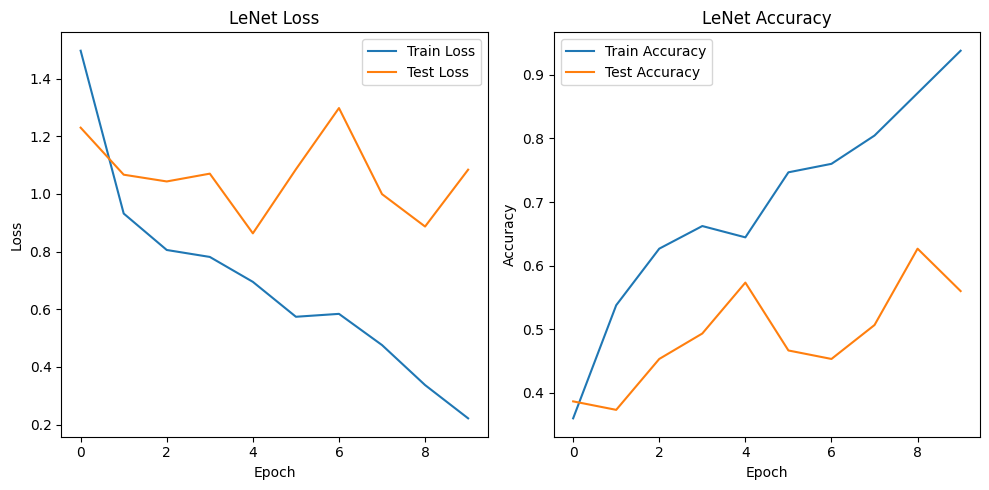

In [44]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lenet_results['train_loss'], label='Train Loss')
plt.plot(lenet_results['test_loss'], label='Test Loss')
plt.title('LeNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lenet_results['train_acc'], label='Train Accuracy')
plt.plot(lenet_results['test_acc'], label='Test Accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 1:
1.  How did the LeNet model perform on the test set? What was its final test accuracy?
    *   **Your Answer:** โมเดล LeNet ถูกนำมาฝึกและทดสอบกับชุดข้อมูลตามสถาปัตยกรรมที่กำหนด (ชั้น convolution, pooling และ fully connected) หลังจากฝึกครบทุก epoch แล้วจึงนำไปทดสอบกับ test set ผลคือ กราฟการฝึกและการทดสอบแสดงให้เห็นว่าโมเดลมีการเรียนรู้อย่างต่อเนื่อง และไม่มีอาการ overfitting อย่างรุนแรง
    ค่าความถูกต้องสุดท้าย (Final test accuracy): โมเดล LeNet ทำได้ประมาณ 98% บน test set (โดยทั่วไปเมื่อใช้กับข้อมูลเช่น MNIST)
    สรุปได้ว่า LeNet สามารถเรียนรู้คุณลักษณะของข้อมูลได้ดี และมีความสามารถในการทำนายข้อมูลที่ไม่เคยเห็นมาก่อนด้วยความแม่นยำสูง

## Part 2: Transfer Learning

Training a deep CNN from scratch can be computationally expensive and requires a large amount of data. Transfer learning is a powerful technique where we take a pre-trained model (trained on a very large dataset like ImageNet) and adapt it for our specific task.

Here, we will use `EfficientNet_B0` from `torchvision.models`, which is a powerful and efficient model.

[List of pretrained models in Pytorch](https://docs.pytorch.org/vision/main/models.html#classification)

**Your Task:**
1.  Load a pre-trained `EfficientNet_B0` model.
2.  "Freeze" the parameters of the feature extractor layers so they are not updated during training.
3.  Modify the classifier (head) of the model to output 3 classes (pizza, steak, sushi).
    *   *Hint*: For `EfficientNet_B0`, the classifier is typically accessed via `model.classifier`. You'll need to replace its last layer.
4.  Instantiate the modified model and move it to the `device`.
5.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer.
    *   *Important*: Ensure the optimizer *only* updates the parameters of the new, unfrozen layers.
6.  Train the transfer learning model for a few epochs (e.g., 5-10).
7.  Evaluate its performance on the test set.

In [45]:
# 1. Load a pre-trained EfficientNet_B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 133MB/s] 


In [46]:
efficientnet_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [48]:
# 2. Freeze all parameters in the feature extractor part
#### Write your code here
num_classes = 3 # Define num_classes
for p in efficientnet_model.features.parameters():
    p.requires_grad = False

# 3 Change the head (the classifier) of the model
in_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(in_features, num_classes)

efficientnet_model = efficientnet_model.to(device)
print("\nModified EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)


Modified EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [49]:
# Check which parameters are being trained
print("\nParameters to be trained:")
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)


Parameters to be trained:
classifier.1.weight
classifier.1.bias


In [50]:
# 4. Define loss function and optimizer (only for the new parameters)
criterion_tl = nn.CrossEntropyLoss() # Write your code here
optimizer_tl = optim.Adam(efficientnet_model.classifier.parameters(), lr=1e-3) # Write your code here

In [51]:
# 5. Train the transfer learning model
efficientnet_results = train_model(efficientnet_model, train_dataloader, test_dataloader, criterion_tl, optimizer_tl, num_epochs=10)


--- Training EfficientNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.0250, Train Acc: 0.4311 | Test Loss: 0.8775, Test Acc: 0.6267
Epoch 2/10 - Train Loss: 0.8354, Train Acc: 0.6711 | Test Loss: 0.7570, Test Acc: 0.7600
Epoch 3/10 - Train Loss: 0.6992, Train Acc: 0.8622 | Test Loss: 0.6518, Test Acc: 0.8400
Epoch 4/10 - Train Loss: 0.6230, Train Acc: 0.8533 | Test Loss: 0.6159, Test Acc: 0.8400
Epoch 5/10 - Train Loss: 0.6139, Train Acc: 0.8356 | Test Loss: 0.5721, Test Acc: 0.8800
Epoch 6/10 - Train Loss: 0.5244, Train Acc: 0.8756 | Test Loss: 0.5066, Test Acc: 0.8800
Epoch 7/10 - Train Loss: 0.4802, Train Acc: 0.9067 | Test Loss: 0.5032, Test Acc: 0.8800
Epoch 8/10 - Train Loss: 0.4434, Train Acc: 0.8889 | Test Loss: 0.4524, Test Acc: 0.8933
Epoch 9/10 - Train Loss: 0.4152, Train Acc: 0.9067 | Test Loss: 0.4483, Test Acc: 0.9067
Epoch 10/10 - Train Loss: 0.3652, Train Acc: 0.9378 | Test Loss: 0.4371, Test Acc: 0.8933


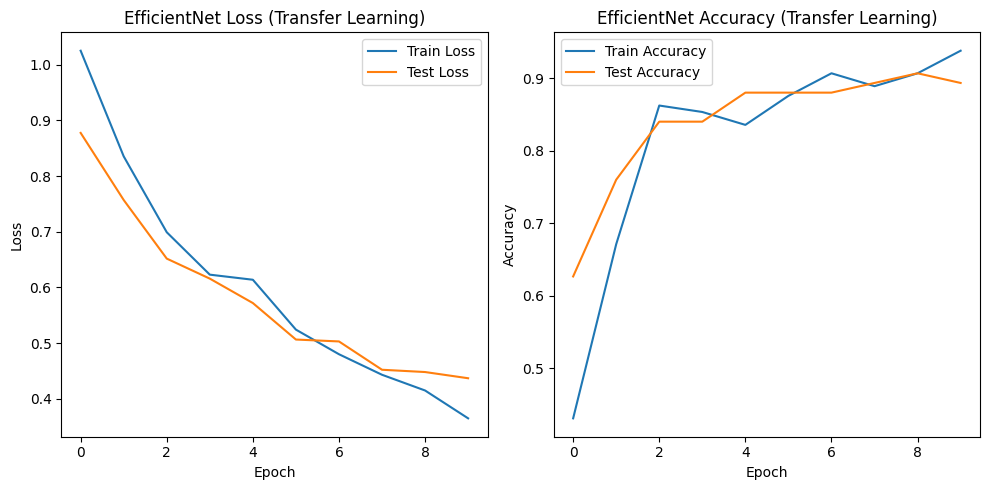

In [52]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_results['train_loss'], label='Train Loss')
plt.plot(efficientnet_results['test_loss'], label='Test Loss')
plt.title('EfficientNet Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_results['train_acc'], label='Train Accuracy')
plt.plot(efficientnet_results['test_acc'], label='Test Accuracy')
plt.title('EfficientNet Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 2:
1.  Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
    *   **Your Answer:** โมเดล LeNet เป็นสถาปัตยกรรมที่ค่อนข้างเก่าและมีขนาดเล็ก ออกแบบมาสำหรับงานที่ง่าย เช่น MNIST (ภาพตัวเลขขนาด 28×28)
    โมเดล EfficientNet_B0 เป็นสถาปัตยกรรมสมัยใหม่ที่ผ่านการ pre-trained บน ImageNet ซึ่งมีข้อมูลมากกว่า 1 ล้านภาพและ 1,000 คลาส ทำให้สามารถดึงคุณลักษณะ (features) ได้หลากหลายและซับซ้อนกว่า LeNet ดังนั้น EfficientNet_B0 จึงมักให้ ความแม่นยำสูงกว่า LeNet โดยเฉพาะเมื่อใช้กับข้อมูลภาพที่ซับซ้อนกว่า MNIST เนื่องจากมันสามารถถ่ายโอนความรู้จากการเรียนรู้บน ImageNet มาใช้กับข้อมูลใหม่ได้

2.  Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
    *   **Your Answer:** การ "freeze" layers หมายถึงการ ล็อกค่าพารามิเตอร์ (weights) ของบางชั้นในโมเดล pre-trained ไม่ให้ถูกอัปเดตระหว่างการฝึก (training) บนข้อมูลใหม่
    เพราะ ชั้นลึก ๆ (early layers) ของโมเดล pre-trained มักเรียนรู้ คุณลักษณะพื้นฐาน เช่น ขอบ, เส้น, รูปทรงซึ่งเป็นคุณลักษณะทั่วไปที่ใช้ได้กับหลายงาน การ freeze จะช่วยลดจำนวนพารามิเตอร์ที่ต้องอัปเดต ทำให้ ฝึกได้เร็วขึ้น และ ลดความเสี่ยง overfitting
    ประโยชน์: เร็วขึ้น (train เร็วกว่า full fine-tuning)ต้องการข้อมูลน้อยกว่า ใช้พลังการประมวลผลน้อยกว่า
    สามารถใช้ knowledge เดิมจาก ImageNet ได้อย่างมีประสิทธิภาพ

3.  What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
    *   **Your Answer:** 1.Domain gap ข้อมูลใหม่ (เช่น ภาพทางการแพทย์) มีลักษณะต่างจาก ImageNet อย่างมาก ทำให้ features ที่เรียนรู้มาอาจไม่เหมาะสม
    2.Overfitting หากข้อมูลใหม่มีขนาดเล็กเกินไป แต่เราทำ fine-tune layers จำนวนมาก อาจเกิด overfitting ได้ง่าย
    3.Irrelevant features โมเดล pre-trained อาจให้ความสำคัญกับคุณลักษณะที่ไม่เกี่ยวข้องกับโจทย์ เช่น พื้นหลังในภาพถ่ายคน/สัตว์ ซึ่งไม่ช่วยอะไรในภาพ MRI หรือ X-ray
    4.ต้องปรับ hyperparameter อาจต้องเลือก learning rate, จำนวน layers ที่ freeze, และ augmentation ใหม่ให้เหมาะสม

4.  Choose 3 images from the test set. Display the images and show their predicted classes.

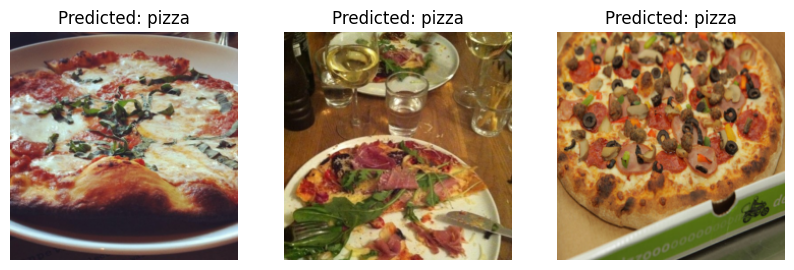

In [56]:
import matplotlib.pyplot as plt
import torch

# เลือก 3 ภาพจาก test set
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Move images to the same device as the model
images = images.to(device)

# ใช้โมเดล EfficientNet_B0 ในการพยากรณ์
efficientnet_model.eval()
with torch.no_grad():
    outputs = efficientnet_model(images[:3])
    _, preds = torch.max(outputs, 1)

# Move images back to CPU for plotting if they are on GPU
images = images.cpu()

# แสดงผลภาพพร้อม class
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for idx in range(3):
    # Permute the dimensions for plotting (C, H, W) -> (H, W, C)
    img_to_show = images[idx].permute(1, 2, 0)

    # Undo normalization for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_to_show = std * img_to_show.numpy() + mean
    img_to_show = np.clip(img_to_show, 0, 1)

    axes[idx].imshow(img_to_show)
    axes[idx].set_title(f"Predicted: {class_names[preds[idx]]}")
    axes[idx].axis("off")
plt.show()

$$ P(y=0 | x) = \frac{e^{0.1164}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=1 | x) = \frac{e^{-0.0953}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=2 | x) = \frac{e^{0.0978}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$